# 1 - Introduction

Le projet est de prédire le code type des produits de Rakuten à partir de données textuelles (désignation et description des produits) ainsi que des données images.<br>
Il est basé sur le challenge https://challengedata.ens.fr/challenges/35

Les données comprennent :
- 3 fichiers CSV (1 comprenant les données textuelles du jeu d'entrainement, 1 pour celles du test et 1 avec les labels du jeu d'entrainement)
- un dossier comprenant toutes les images 

Dans ce notebook nous faisons une première exploration des données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import cv2


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# importation des données du jeu d'entraînement

data_path = "../data/raw/"
df = pd.read_csv(data_path+"X_train_update.csv").drop("Unnamed: 0", axis=1)
y = pd.read_csv(data_path+"Y_train_CVw08PX.csv")['prdtypecode']
df = pd.concat([y, df], axis=1)

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None


,prdtypecode,designation,description,productid,imageid
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


Il n'y a pas toujours de descriptions mais les designations ne sont jamais NaN, ni les productid et les imageid qui vont nous servir à récupérer les images car les noms des fichiers images sont de la forme image_*imageid*\_product_*productid*.jpg <br>
Nous allons vérifier que chaque porductid et imageid est unique et récupérer les chemins des images dans la variable "image".

In [3]:
print(f"Il y a {df['productid'].duplicated(keep=False).sum()} duplicata pour productid")
print(f"Il y a {df['imageid'].duplicated(keep=False).sum()} duplicata pour imageid")

# on enregistre le chemin de l'image correspondant à chaque article dans une colonne image
df['image'] = data_path +"images/image_train/image_" + df['imageid'].astype('str') + '_product_' + df['productid'].astype('str') +'.jpg'

Il y a 0 duplicata pour productid
Il y a 0 duplicata pour imageid


Les productid sont tous uniques on peut donc réindexer df par cette colonne. Les imageid ne sont plus nécessaire maintenant qu'on a récupérer le chemin on va donc supprimer la colonne imageid.

In [4]:
df = df.set_index("productid").drop('imageid', axis=1)

# 2 - Nettoyage du texte

En regardant les designations et les descriptions on peut remarquer que certains textes comportent des balises html, des entités html et des caractères qui semblent mals encodés. Nous allons donc écrire une fonction qui permet de nettoyer le texte à l'aide des librairie regex, html (pour traîter les entités html) et ftfy et unicodedata (pour la gestion de l'encodage).

In [5]:
import regex as reg
import html, ftfy, unicodedata

# Fonction pour nettoyer et standardiser les données textuelles:
def nettoyer_texte(text):
    if pd.isna(text): return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)          # Supprime HTML
    s = html.unescape(s)                     # Décode entités HTML
    s = ftfy.fix_text(s)                     # Corrige texte cassé
    s = unicodedata.normalize("NFC", s)      # Normalise Unicode
    s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)  # Supprime points non numériques
    s = s.replace("/", " ")
    s = s.replace("*", " ")
    s = s.replace(":", " ")
    s = s.replace("-", " ")
    s = s.replace("////", " ")    
    s = reg.sub(r"\s+", " ", s).strip()     # Nettoie espaces et casse
    return s

# Le texte de ce produit rencontre les problèmes décrits nous allons donc tester la fonction de nettoyage dessus
productid = 4108914287                      
description = df.iloc[14]['description']

print(f"--- productid {productid} [texte original] ---")
print(description)
print("\n" + "="*40 + "\n")
print(f"--- productid {productid} [texte nettoyé] ---")
print(nettoyer_texte(description))

--- productid 4108914287 [texte original] ---
MATELAS:<br />Â· Accueil : Ferme .<br />Â· Soutien : Très Ferme .<br />Â· Technologie matelas : Face été &#43; à¢me en Mousse Poli Lattex Dernière Génération Indéformable Très Haute Résilience - Face Hiver 45 cm de Mousse à  Mémoire de Forme Très Haute Densité 60 Kg/m3 &#34; Massante&#34;<br />Â· Épaisseur du matelas : &#43;/- 20 cm.<br />Â· REPOS PLUS SAIN grà¢ce au Traitement Anti-acariens / anti-bactérien / Anti-moisissures.<br />Â· Très Bonne Indépendance de couchage.<br />Â· DORMEZ TRANQUILLE avec la Garantie 5 ans.  Il est Compatible avec les Sommiers Mécaniques et électriques<br />Coutil:<br />Â· Coutil stretch matelassé de 290 gr/m2 de Polyester avec traitement Sanitized. Faces de couchage Réversibles - Déhoussable sur 3 Cà¿tés et Housse Lavable à  30Â° position Lavage à  la main Délicat -<br />Â· SANITIZED : Traitement antibactérien et anti-moisissures diminuant également le développement des odeurs.<br />Structure et garnissage du

Nous pouvons vérifier si cette fonction permet de detecter des doublons textuelles supplémentaire

In [6]:
df["cleaned_designation"] = df["designation"].apply(nettoyer_texte)
df["cleaned_description"] = df["description"].apply(nettoyer_texte)

print(f"Avant nettoyage il y a {df[["designation", "description", "prdtypecode"]].duplicated(keep=False).sum()} duplicata textuels.")
print(f"Après nettoyage il y a {df[["cleaned_designation", "cleaned_description", "prdtypecode"]].duplicated(keep=False).sum()} duplicata textuels.")

Avant nettoyage il y a 2311 duplicata textuels.
Après nettoyage il y a 2370 duplicata textuels.


# 3 - Doublons (texte + image)

Pour identifier les lignes qui sont de véritables doublons, il faudrait vérifier qu'en plus d'un texte identique, elles aient des images identiques. Pour comparer les images nous allons utiliser la méthode de hashage hash pour attribuer un identifiant à chaque photos. Cette identifiant sera différents quand deux photos seront différentes sinon il sera identique.

In [7]:
# génère le hashage en fonction d'une liste de chemin

def generate_hash(paths):
    hashed_contents = []
    for path in paths:
        with open(path, 'rb') as f:
            hashed_contents.append(hash(f.read()))  # on récupère le contenu du fichier puis on le hash
    return hashed_contents

df['hashed_image'] = generate_hash(df['image'])

Nous pouvons maintenant vérifier combien notre jeu de données a de doublons et les supprimer

In [8]:
print(f"Il y a {df[['cleaned_designation', 'cleaned_description', 'hashed_image', 'prdtypecode']].duplicated(keep=False).sum()} duplicata.")

df = df.drop_duplicates(subset=['cleaned_designation', 'cleaned_description', 'hashed_image', 'prdtypecode'])

Il y a 634 duplicata.


In [13]:
n_duplicata_wdiff_prdtypecode = df[['cleaned_designation', 'cleaned_description', 'hashed_image']].duplicated(keep=False).sum()
print(f"Il y a {n_duplicata_wdiff_prdtypecode} lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.")

Il y a 16 lignes qui ont un doublon sur le texte et l'image mais avec un prdtypecode différent.


Certains produits identiques sont classés dans plusieurs catégories. Il faudra analyser si des catégories se "chevauchent" ou si ce sont plutôt des produits rangé dans la mauvaise catégorie. Pour commencer nous allons identifier les différentes catégories.

# 4 - Identification des catégories

Dans le but d'identifier les catégories correspondant à chaque code produit, il serait interessant d'afficher les images et les descriptions complètent ensemble. On va utiliser la fonction *display_df* qui permet d'afficher les images dans les cellules du dataframe à partir de leur chemin.

In [21]:
# fonction qui permet d'afficher les images du dataframe à partir du chemin des images
# et également les descriptions complètes

from IPython.display import HTML

def display_df(df, max_length=5):
    formatters={
        "image": lambda path: f'<img src="{path}" width="200">',
    }
    display(HTML(df.head(max_length).to_html(escape=False, formatters=formatters)))

# on affiche les premières lignes de la catégorie de code 10 avec l'image correspondante
display_df(df[df['prdtypecode']==10][['cleaned_designation', 'cleaned_description', 'image']], 3)

,cleaned_designation,cleaned_description,image
productid,,,
3804725264,Olivia Personalisiertes Notizbuch 150 Seiten Punktraster Ca Din A5 Rosen Design,,
91920807,Christof E Bildungsprozessen Auf Der Spur,,
444108636,Vassivière En Limousin Le Jardin Art Et Lieu De Mémoire,,


Ici la catégorie 10 semble représenter des livres. Pour pouvoir les identifier plus facilement nous allons afficher des grilles d'images et de nuages de mots. Pour générer les nuages de mots nous allons d'abord définir une liste stop_words des mots à exclure de nos nuages de mots, puis faire une vectorisation par score TF-IDF pour que les nuages de mots soit plus spécifique à chaque catégorie.

In [22]:
# permet d'affichier une grille d'images de nrows x ncols

def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(1.5*ncols,1.5*nrows))
    axes = axes.flatten()
    for i in range(nrows*ncols):
        if i < len(images):
            axes[i].imshow(images[i], cmap=cmap)
            if titles:
                axes[i].set_title(titles[i], fontsize=8)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.show()


stop_words = set(stopwords.words('french'))   # on récupère un stopwords adapté au français

# le paramètre ngram_range=(1,2) permet de récupérer unigramme et bigramme
# (par default c'est uniquement les unigrammes, i.e. séquence de un seul mot)
vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(stop_words), ngram_range=(1,2))

text = df["designation"] + " - " + df["description"].fillna("")
tfidf = vectorizer.fit_transform(text)

tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
tfidf["prdtypecode"] = df["prdtypecode"].values
means_by_prdtypecode = tfidf.groupby("prdtypecode").mean()
freqs = {
    str(code) : means_by_prdtypecode.loc[code].sort_values(ascending=False)
    for code in tfidf["prdtypecode"].sort_values().unique()
}

# inclure Marta grilles d'images

### voir pourquoi le br des balises html semblent rester ?

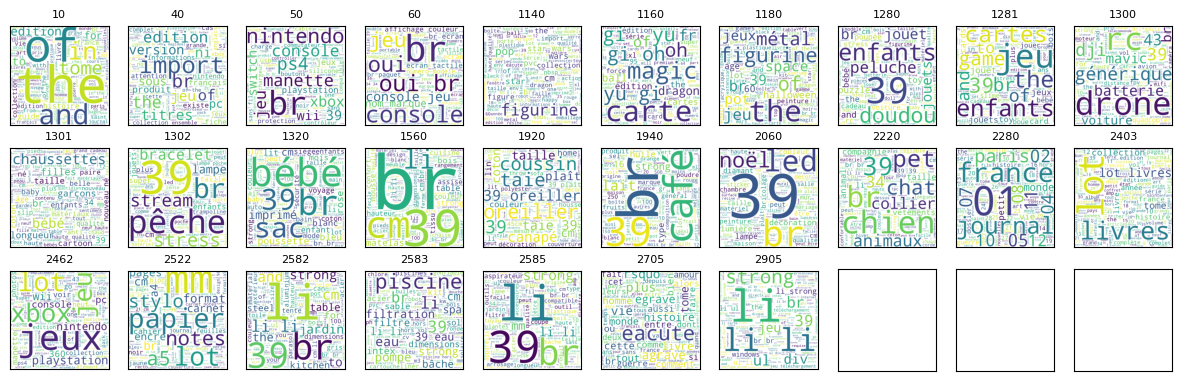

In [24]:
wc = [WordCloud(width=500, height=500, background_color="white").generate_from_frequencies(f) for f in freqs.values()]
images_grid(wc, 3, 10, titles=list(freqs))